#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor, Pool
import catboost as cat
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
from itertools import product
from sklearn.model_selection import cross_val_score


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller


import seaborn as sns
import collections
sns.set(style = 'darkgrid', palette = 'Set2')

import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [3]:
taxi.sort_index(inplace = True)
taxi.index.is_monotonic

True

In [4]:
display(taxi.head())
taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi = taxi.resample('1H').sum()
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Нам была дана таблица с 24 496 данными о количестве заказазов в каждые 10 минут. 
Для анализа ресемплировали, чтобы получит количество заказлв каждый час.

## Анализ

Text(0, 0.5, 'orders')

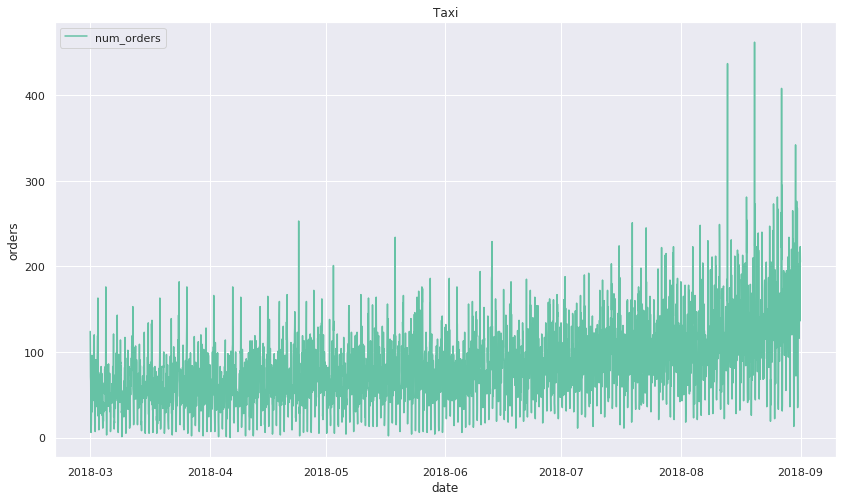

In [6]:
plt.figure(figsize=(14,8))
sns.lineplot(data=taxi)

plt.legend()
plt.title('Taxi')
plt.xlabel('date')
plt.ylabel('orders')

In [7]:
adfuller(taxi["num_orders"])

(-3.068924289027949,
 0.02894005140261345,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

Ряд можно считать стационарным: критическое значение = -3.06 < -2.86(5-% доверительный интервал).
Изучим тренды и сезонность.

Text(0, 0.5, 'orders')

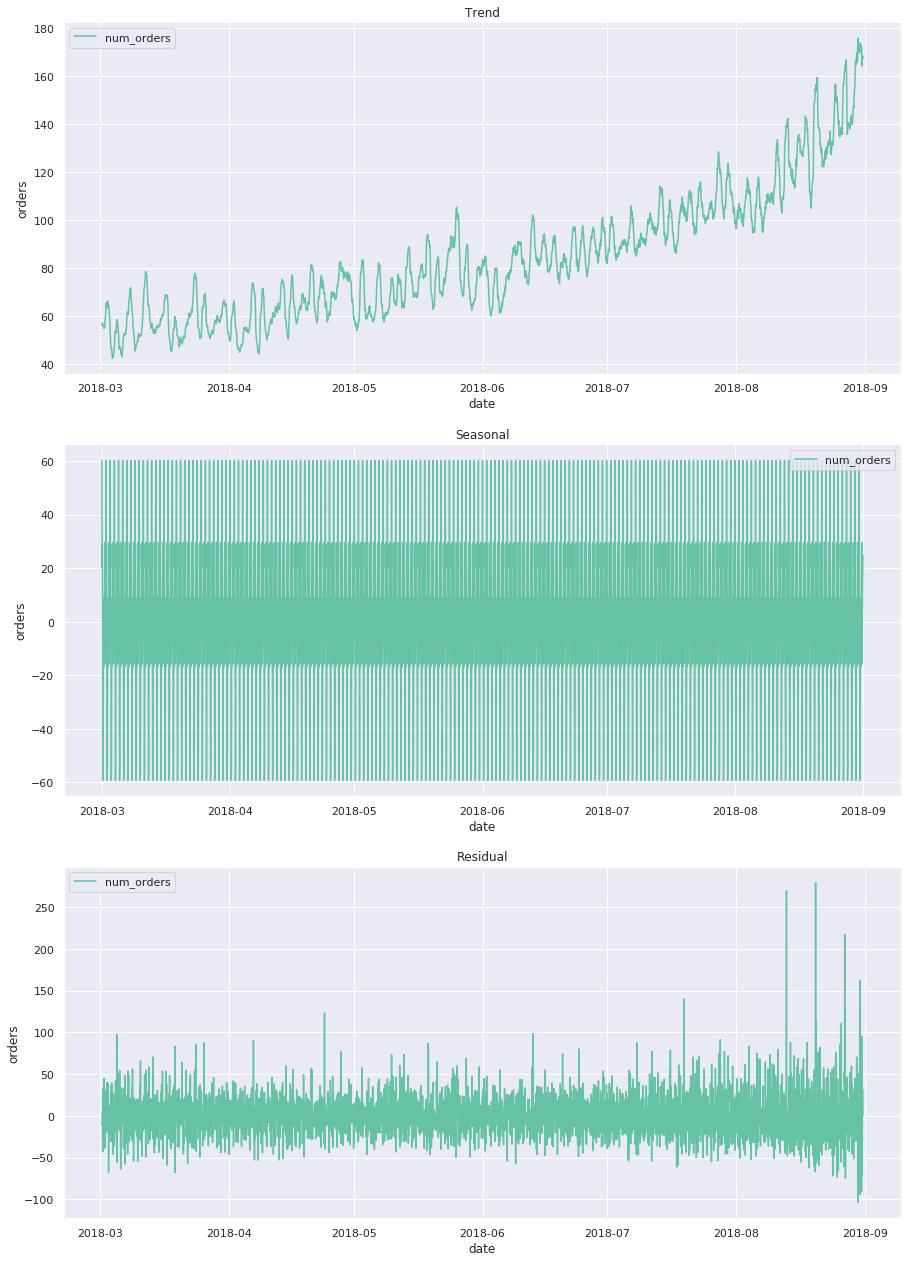

In [8]:
decomposed = seasonal_decompose(taxi)

fig, axs = plt.subplots(3, 1, figsize=(15,22))
sns.lineplot(data=decomposed.trend, ax=axs[0])
axs[0].set_title('Trend')
axs[0].set_xlabel('date')
axs[0].set_ylabel('orders')

sns.lineplot(data=decomposed.seasonal, ax=axs[1])
axs[1].set_title('Seasonal')
axs[1].set_xlabel('date')
axs[1].set_ylabel('orders')

sns.lineplot(data=decomposed.resid, ax=axs[2])
axs[2].set_title('Residual')
axs[2].set_xlabel('date')
axs[2].set_ylabel('orders')

In [9]:
decomposedWeek = seasonal_decompose(taxi['2018-03-04':'2018-03-12'])
decomposedFewDays = seasonal_decompose(taxi['2018-03-04':'2018-03-06'])
decomposedMonth_apr = seasonal_decompose(taxi['2018-04-01':'2018-05-01'])
decomposedMonth_aug = seasonal_decompose(taxi['2018-07-31':'2018-08-31'])

Text(0, 0.5, 'orders')

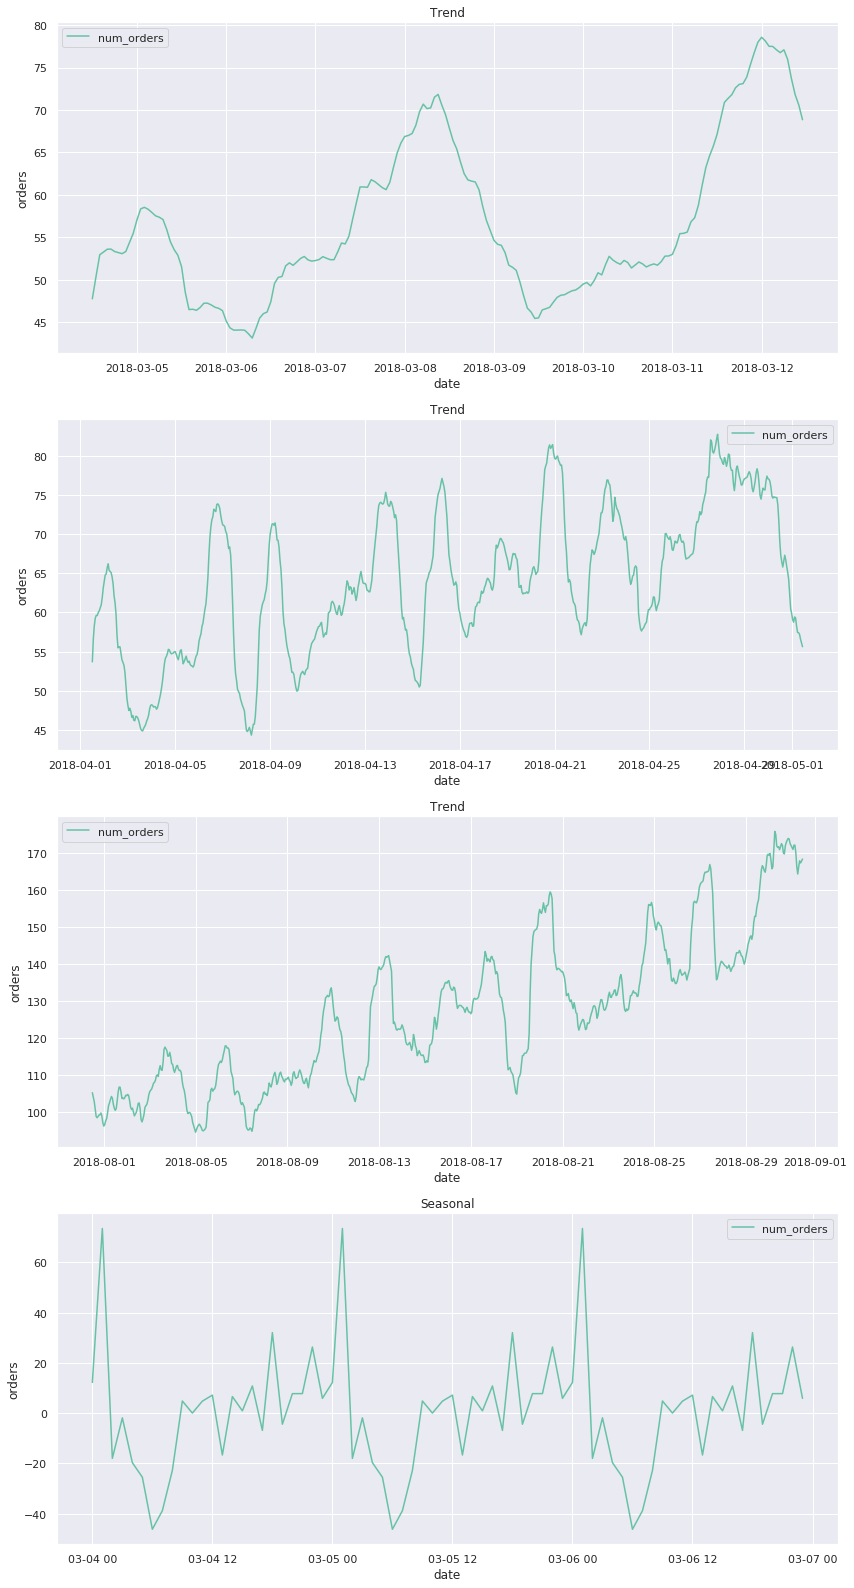

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(14, 28))
sns.lineplot(data=decomposedWeek.trend, ax=axs[0])
axs[0].set_title('Trend')
axs[0].set_xlabel('date')
axs[0].set_ylabel('orders')

sns.lineplot(data=decomposedMonth_apr.trend, ax=axs[1])
axs[1].set_title('Trend')
axs[1].set_xlabel('date')
axs[1].set_ylabel('orders')


sns.lineplot(data=decomposedMonth_aug.trend, ax=axs[2])
axs[2].set_title('Trend')
axs[2].set_xlabel('date')
axs[2].set_ylabel('orders')

sns.lineplot(data=decomposedFewDays.seasonal, ax=axs[3])
axs[3].set_title('Seasonal')
axs[3].set_xlabel('date')
axs[3].set_ylabel('orders')

Тренды:

Весь датасет: в летний период количество заказов растет.

Неделя из датасета: 5 марта 2018 года (понедельник) - 11 марта 2018 года (воскресенье),спрос слабее во вторник, субботу и воскресенье.

Апрель и август: ситуация схожа с днями недели. Дополнительно, к концу каждого месяца увеличивается число заказов, но летом этот рост значительнее.

Сезонность по часам: утром самые низкие показатели заказов, которые относительно нормализуются к 12, ночью наблюдаем скачок.

Text(0, 0.5, 'orders')

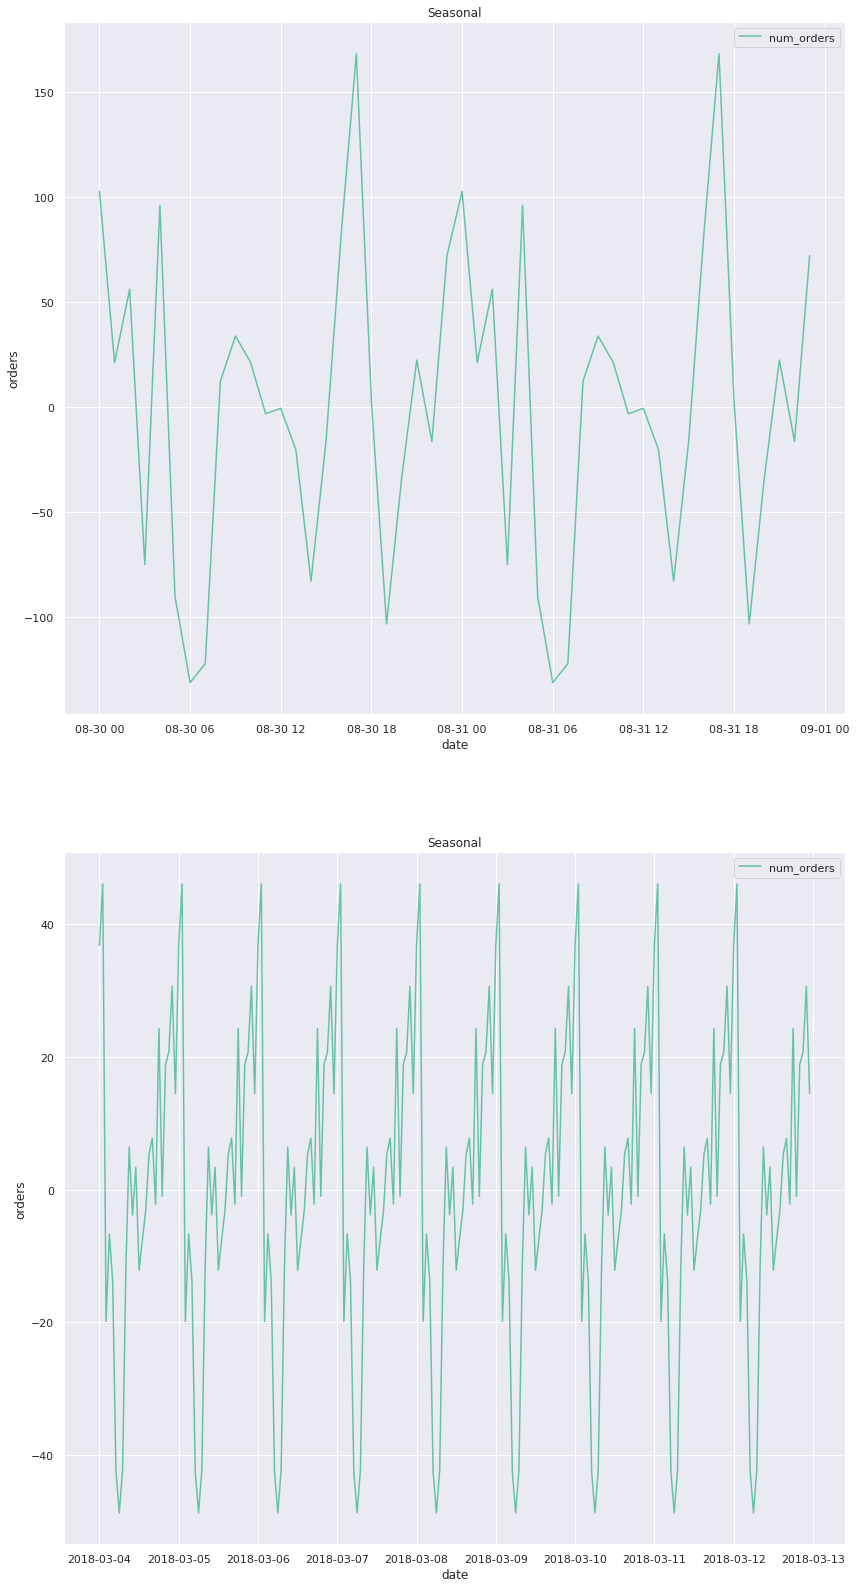

In [11]:
decomposed_taxi_24h = seasonal_decompose(taxi['2018-08-30':'2018-08-31'])

fig, axs = plt.subplots(2, 1, figsize=(14, 28))
sns.lineplot(data=decomposed_taxi_24h.seasonal, ax=axs[0])
axs[0].set_title('Seasonal')
axs[0].set_xlabel('date')
axs[0].set_ylabel('orders')

sns.lineplot(data=decomposedWeek.seasonal, ax=axs[1])
axs[1].set_title('Seasonal')
axs[1].set_xlabel('date')
axs[1].set_ylabel('orders')

Введем несколько признаков:

- day - видна ежедневная сезонность.
- dayofweek - к концу недели идет увеличение заказов.
- month- из месяца в месяц данные отличаются, но носят цикличный характер.

Нужно определить количество lag признаков, для этого попробуем найти разницу в часах между ночным пиком (max) и пиком в сезонном сегменте(min).
Помимо этого нужно определить rolling_mean, поэтому определим, какое окно в скользяще среднем лучше всего напоминает данные.

In [12]:
decomposed_taxi_24h = seasonal_decompose(taxi['2018-08-30':'2018-08-31'])

max_lag = ((decomposed_taxi_24h.seasonal.idxmax() - decomposed_taxi_24h.seasonal.idxmin()) 
            // np.timedelta64(1, 'h'))[0]

max_lag

11

In [13]:
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data = taxi['2018-08-30':'2018-08-31']
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    rolling_mean_size_dict[rolling_mean_size] = RMSE
    
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

33

Теперь можно перейти к созданию признаков.

In [14]:
def make_features(data, column, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in (1, 2, 3, 24, 48, 72, 168, 336):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [15]:
taxi_copy = taxi.copy()
make_features(taxi,'num_orders', 4)

train, test = train_test_split(taxi, shuffle=False, test_size=0.2)
valid,test = train_test_split(test,shuffle = False, test_size = 0.5)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

In [16]:
taxi

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_24,lag_48,lag_72,lag_168,lag_336,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,NaN,NaN,NaN,NaN,NaN,86.50
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,72.0,169.0,111.0,113.0,84.0,184.25
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,142.0,191.0,94.0,179.0,126.0,189.25
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,198.0,170.0,189.0,166.0,144.0,178.50


- данные проанализированы
- признаки созданы
- подготовка к обучению завершена

## Обучение

In [17]:
splits = TimeSeriesSplit(n_splits=8)

In [18]:
%%time

regressor = ExtraTreesRegressor() 
max_depth_list = [x for x in range(3, 8)]
hyperparams = [{'criterion':['mse'],
                'max_depth':max_depth_list, 
                'n_estimators':[x for x in range(100, 150, 10)],
                'random_state':[42]}]

ETR_grid = GridSearchCV(regressor, hyperparams, cv=splits, scoring='neg_mean_squared_error',verbose=True)
ETR_grid.fit(features_train, target_train)

Fitting 8 folds for each of 25 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.3s finished


CPU times: user 27.2 s, sys: 133 ms, total: 27.3 s
Wall time: 27.5 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators='warn', n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'criterion': ['mse'], 'max_depth': [

CatBoost



In [19]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE', random_state = 123)
parameters_cat = {'depth':[5, 7, 10], 'learning_rate':[0.03, 0.05, 0.15]}
catboost_grid = catboost.grid_search(parameters_cat,
                    Pool(features_train, target_train),cv=splits,verbose=True)

0:	loss: 23.0751794	best: 23.0751794 (0)	total: 10.3s	remaining: 1m 22s
1:	loss: 23.0764871	best: 23.0751794 (0)	total: 19.8s	remaining: 1m 9s
2:	loss: 23.3114632	best: 23.0751794 (0)	total: 29s	remaining: 57.9s
3:	loss: 22.8890689	best: 22.8890689 (3)	total: 46.8s	remaining: 58.5s
4:	loss: 23.0391555	best: 22.8890689 (3)	total: 1m 4s	remaining: 51.5s
5:	loss: 23.4722416	best: 22.8890689 (3)	total: 1m 22s	remaining: 41.2s
6:	loss: 23.2948957	best: 22.8890689 (3)	total: 2m 22s	remaining: 40.8s
7:	loss: 23.3546526	best: 22.8890689 (3)	total: 3m 22s	remaining: 25.3s
8:	loss: 23.8667372	best: 22.8890689 (3)	total: 4m 22s	remaining: 0us
Estimating final quality...
CPU times: user 6min 5s, sys: 40.6 s, total: 6min 46s
Wall time: 9min 1s


In [20]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train, target_train))

0:	learn: 35.2151797	total: 2.28ms	remaining: 2.27s
100:	learn: 19.0788553	total: 1.75s	remaining: 15.5s
200:	learn: 17.9387352	total: 3.62s	remaining: 14.4s
300:	learn: 17.1760430	total: 5.57s	remaining: 12.9s
400:	learn: 16.4207540	total: 7.35s	remaining: 11s
500:	learn: 15.7242059	total: 9.22s	remaining: 9.19s
600:	learn: 15.0408722	total: 11.2s	remaining: 7.42s
700:	learn: 14.4654672	total: 13s	remaining: 5.53s
800:	learn: 13.8292279	total: 14.8s	remaining: 3.68s
900:	learn: 13.2835469	total: 16.7s	remaining: 1.83s
999:	learn: 12.7456311	total: 18.6s	remaining: 0us
CPU times: user 16.4 s, sys: 2.39 s, total: 18.8 s
Wall time: 20.4 s


In [21]:
catboost_grid["params"]["depth"]

7

LightGBM

In [23]:
%%time

lgb_train = lgb.Dataset(features_train, target_train)
lgb_valid = lgb.Dataset(features_valid, target_valid, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 1234567,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_valid],
                verbose_eval=100)

[100]	training's l2: 169.217	valid_1's l2: 868.606
[200]	training's l2: 100.392	valid_1's l2: 902.24
[300]	training's l2: 62.5177	valid_1's l2: 913.77
[400]	training's l2: 38.7132	valid_1's l2: 922.491
[500]	training's l2: 24.7309	valid_1's l2: 928.308
[600]	training's l2: 15.9704	valid_1's l2: 930.507
[700]	training's l2: 10.1046	valid_1's l2: 932.336
[800]	training's l2: 6.6998	valid_1's l2: 935.044
[900]	training's l2: 4.6765	valid_1's l2: 935.993
[1000]	training's l2: 3.13698	valid_1's l2: 936.851
CPU times: user 8.93 s, sys: 25 ms, total: 8.96 s
Wall time: 8.96 s


## Тестирование

In [24]:
    # ExtraTreesRegressor
    
# Valid
preds_ETR_valid = ETR_grid.best_estimator_.predict(features_valid)

# Test
ETR_test_start_time = time.time()
preds_ETR_test = ETR_grid.best_estimator_.predict(features_test)
ETR_test_total_time = time.time() - ETR_test_start_time

# Train
preds_ETR_train = ETR_grid.best_estimator_.predict(features_train)

In [25]:
    # CatBoost
    
# Valid
preds_Cat_valid = final_cat.predict(features_valid)

# Test
CatBoost_test_start_time = time.time()
preds_Cat_test = final_cat.predict(features_test)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time

# Train
preds_Cat_train = final_cat.predict(features_train)

In [26]:
   #LightGBM

# Valid
preds_Light_valid = light.predict(features_valid)
 
# Test
LightGBM_test_start_time = time.time()
preds_Light_test = light.predict(features_test)
LightGBM_test_total_time = time.time() - LightGBM_test_start_time

# Train
preds_Light_train = light.predict(features_train)

In [27]:
#Train
    # ExtraTreesRegressor
RMSE_ETR_train = (mean_squared_error(target_train, preds_ETR_train))**0.5
    # CatBoost
RMSE_CatBoost_train = (mean_squared_error(target_train, preds_Cat_train))**0.5
    #LightGBM
RMSE_LightGBM_train = (mean_squared_error(target_train, preds_Light_train))**0.5

# Valid
    # ExtraTreesRegressor
RMSE_ETR_valid = (mean_squared_error(target_valid, preds_ETR_valid))**0.5
    # CatBoost
RMSE_CatBoost_valid = (mean_squared_error(target_valid, preds_Cat_valid))**0.5
    #LightGBM
RMSE_LightGBM_valid = (mean_squared_error(target_valid, preds_Light_valid))**0.5

# Test
    # ExtraTreesRegressor
RMSE_ETR_test = (mean_squared_error(target_test, preds_ETR_test))**0.5
    # CatBoost
RMSE_CatBoost_test = (mean_squared_error(target_test, preds_Cat_test))**0.5
    #LightGBM
RMSE_LightGBM_test = (mean_squared_error(target_test, preds_Light_test))**0.5

In [31]:
report = pd.DataFrame(columns = ["ExtraTrees", "CatBoost", "LightGBM"],
                      index = ["RMSE(train)",
                               "RMSE(valid)",
                               "RMSE(test)",
                               "Время обучения, сек",
                               "Время предсказания, сек"])


report.iloc[0] = [RMSE_ETR_train, RMSE_CatBoost_train, RMSE_LightGBM_train]
report.iloc[1] = [RMSE_ETR_valid, RMSE_CatBoost_valid, RMSE_LightGBM_valid]
report.iloc[2] = [RMSE_ETR_test, RMSE_CatBoost_test, RMSE_LightGBM_test]
report.iloc[3] = [27,20,9]
report.iloc[4] = [ETR_test_total_time, CatBoost_test_total_time, LightGBM_test_total_time]

In [32]:
display(report)

,ExtraTrees,CatBoost,LightGBM
RMSE(train),18.0123,12.7456,1.77115
RMSE(valid),30.3049,29.4204,30.608
RMSE(test),46.8437,44.7225,44.9309
"Время обучения, сек",27,20,9
"Время предсказания, сек",0.0099504,0.00487041,0.098208


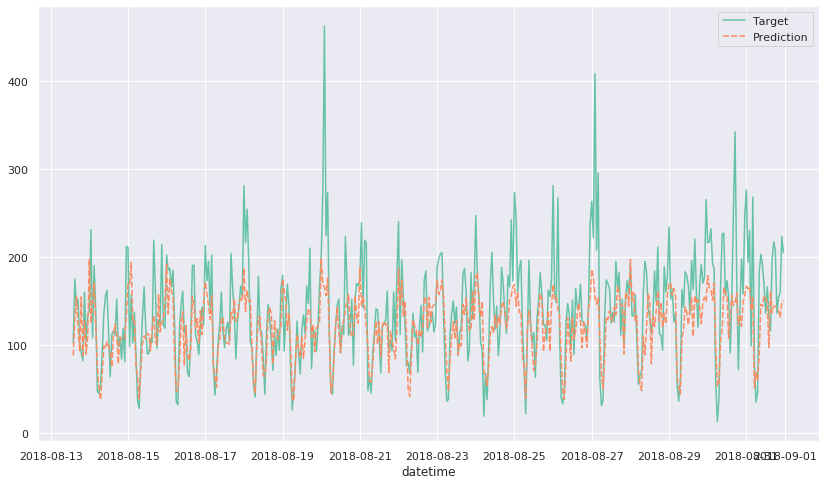

In [30]:
frame = {'Target':target_test, 'Prediction':preds_Light_test}
result = pd.DataFrame(frame)

plt.figure(figsize=(14,8))
sns.lineplot(data=result);

Обучены три различные модели:ExtraTrees, CatBoost, LGBM.
Все модели выполнили условие на тестовой выборке, лучший результат у  CatBoost. Значение RMSE для нее составило 44.72.  Значение RMSE у всех моделей близко, скорость предсказания явно выше у ExtraTrees и CatBoost.